In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.io import readsav
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy import units as u
import astropy.constants as astro_const
import sunpy
from sunpy.coordinates import sun

import os
import sys
import glob
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is stored
data_dir = '/home/mnedal/data'

In [2]:
obs_time = '2024-05-14 17:10:00'

# return the Carrington longitude (central meridian longitude) for a given datetime
clon = sun.L0(time=obs_time).value

# return the Carrington rotation number for a given datetime
crot = sun.carrington_rotation_number(t=obs_time)

# return the datetime for a given Carrington longitude (central meridian longitude)
cobstime = sun.carrington_rotation_time(crot=int(crot), longitude=clon*u.deg).iso

print(f'Carrington longitude: {clon:.5f}')
print(f'Carrington rotation number: {crot:.5f}')
print(f'Carrington observe time: {cobstime}')

Carrington longitude: 251.22813
Carrington rotation number: 2284.30214
Carrington observe time: 2024-05-14 17:09:59.946


In [3]:
sun.carrington_rotation_time(crot=int(crot), longitude=251.22800*u.deg).iso # the default value in FORWARD does not quite refer to the set datetime

'2024-05-14 17:10:00.828'

In [4]:
sun.carrington_rotation_time(crot=int(crot), longitude=251.27914*u.deg).iso # the default value in FORWARD does not quite refer to the set datetime

'2024-05-14 17:04:26.736'

In [5]:
round(sun.carrington_rotation_number(t='2024-05-14 17:10:00.000'), 5)

2284.30214

## Load the data files

In [6]:
file_paths = sorted(glob.glob(f'{data_dir}/FORWARD/*.sav'))
print(*file_paths, sep='\n')

/home/mnedal/data/FORWARD/AIA_20240514_1710_193_512_rfilter.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BETA_2460559.9840394disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BMAG_2460559.9356944disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_DENS_2460559.9343750disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_PTOT_2460559.9832407disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_TEMP_2460559.9822801disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VPH_2460593.4820486disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VR_2460593.4744676disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VTH_2460593.4788194disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VX_2460593.5005556disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VY_2460593.5060301disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VZ_2460593.5081481disk.sav


In [7]:
for file in file_paths:
    if 'BMAG' in file:
        bmag = fwd.get_forward_map(file)
    elif 'DENS' in file:
        dens = fwd.get_forward_map(file)
    elif 'BETA' in file:
        beta = fwd.get_forward_map(file)
    elif 'PRES' in file:
        pres = fwd.get_forward_map(file)
    elif 'PTOT' in file:
        ptot = fwd.get_forward_map(file)
    elif 'TEMP' in file:
        temp = fwd.get_forward_map(file)
    elif 'BR' in file:
        br = fwd.get_forward_map(file)

In [8]:
# Calculate the Alfven speed map
mp = astro_const.m_p.to(u.gram).value
valf_cm_s = bmag.data/np.sqrt(4*np.pi*mp*dens.data)
valf_km_s = valf_cm_s * 1e-5
va = sunpy.map.Map(valf_km_s, dens.meta)

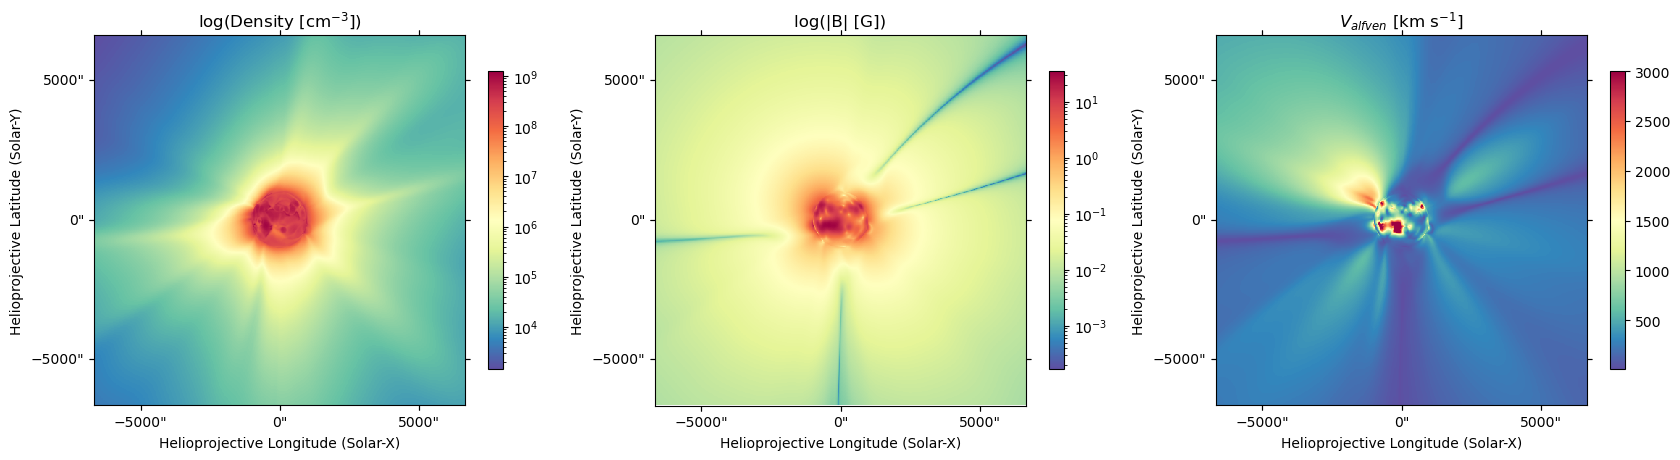

In [9]:
fig = plt.figure(figsize=[17,5])

ax = fig.add_subplot(131, projection=dens)
img = dens.plot(axes=ax, title='log(Density [cm$^{-3}$])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(132, projection=bmag)
img = bmag.plot(axes=ax, title='log(|B| [G])',
                # vmin=0.5e2, vmax=1e4,
                norm=colors.LogNorm(),
                # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
                cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(133, projection=va)
img = va.plot(axes=ax, title='$V_{alfven}$ [km s$^{-1}$]',
            vmin=1e1, vmax=3e3,
            cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

fig.tight_layout()
plt.show()

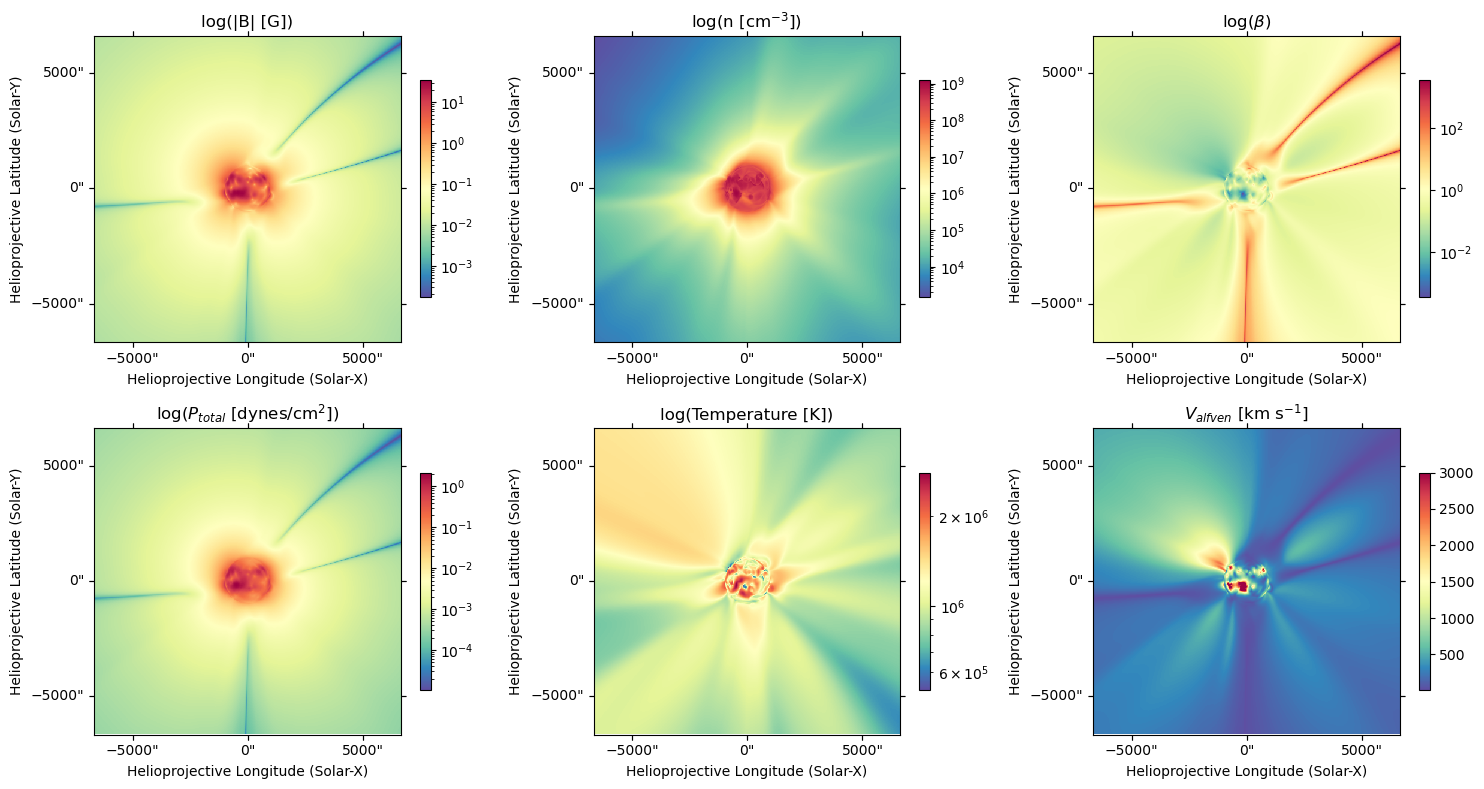

In [10]:
fig = plt.figure(figsize=[15,8])

ax = fig.add_subplot(231, projection=bmag)
img = bmag.plot(axes=ax, title='log(|B| [G])',
                # vmin=0.5e2, vmax=1e4,
                norm=colors.LogNorm(),
                # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
                cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(232, projection=dens)
img = dens.plot(axes=ax, title=r'log(n [cm$^{-3}$])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(233, projection=beta)
img = beta.plot(axes=ax, title=r'log($\beta$)',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(234, projection=ptot)
img = ptot.plot(axes=ax, title=r'log($P_{total}$ [dynes/cm$^2$])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(235, projection=temp)
img = temp.plot(axes=ax, title='log(Temperature [K])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

ax = fig.add_subplot(236, projection=va)
img = va.plot(axes=ax, title=r'$V_{alfven}$ [km s$^{-1}$]',
            vmin=1e1, vmax=3e3,
            cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

fig.tight_layout()
plt.show()

In [17]:
for file in file_paths:
    if 'VX' in file:
        vx = fwd.get_forward_map(file)
    elif 'VY' in file:
        vy = fwd.get_forward_map(file)
    elif 'VZ' in file:
        vz = fwd.get_forward_map(file)
    elif 'VR' in file:
        vr = fwd.get_forward_map(file)
    elif 'VPH' in file:
        vphi = fwd.get_forward_map(file)
    elif 'VTH' in file:
        vtheta = fwd.get_forward_map(file)

In [18]:
vcar = np.sqrt(vx.data**2 + vy.data**2 + vz.data**2)
V_cartesian = sunpy.map.Map(vcar, vx.meta)

vsph = np.sqrt(vr.data**2 + vphi.data**2 + vtheta.data**2)
V_spherical = sunpy.map.Map(vsph, vr.meta)

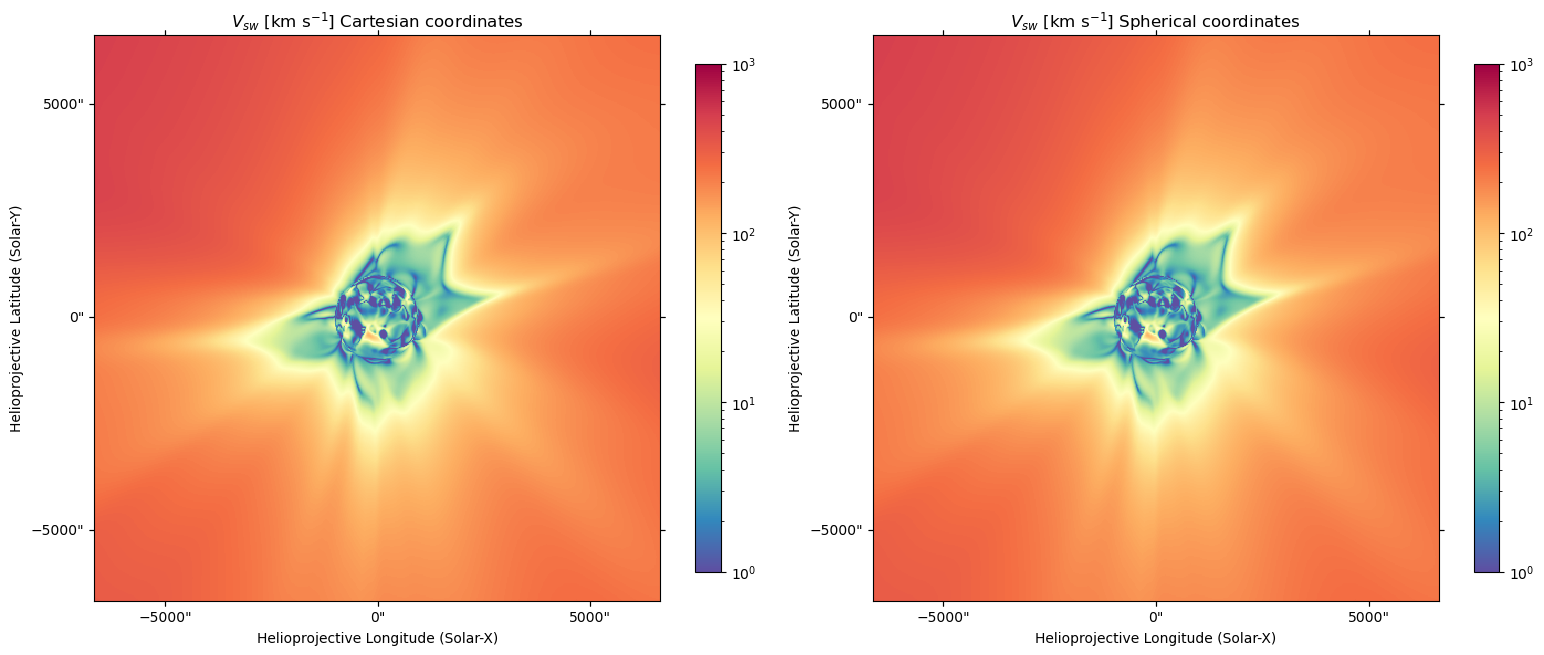

In [37]:
fig = plt.figure(figsize=[16,8])

ax  = fig.add_subplot(121, projection=V_cartesian)
img = V_cartesian.plot(axes=ax, title=r'$V_{sw}$ [km s$^{-1}$] Cartesian coordinates',
            # vmin=1e1, vmax=5e2,
            # norm=colors.LogNorm(),
            norm=colors.LogNorm(vmin=1, vmax=1000),
            cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

ax  = fig.add_subplot(122, projection=V_spherical)
img = V_spherical.plot(axes=ax, title=r'$V_{sw}$ [km s$^{-1}$] Spherical coordinates',
            # vmin=1e1, vmax=5e2,
            # norm=colors.LogNorm(),
            norm=colors.LogNorm(vmin=1, vmax=1000),
            cmap='Spectral_r')
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
ax.grid(False)

fig.tight_layout()
plt.show()

In [45]:
def crop_map(map=None, right=None, top=None, left=None, bottom=None):
    """
    Crop ~sunpy map, given ~SkyCoord boundaries.
    """
    top_right   = SkyCoord(right*u.arcsec, top*u.arcsec, frame=map.coordinate_frame)
    bottom_left = SkyCoord(left*u.arcsec, bottom*u.arcsec, frame=map.coordinate_frame)
    sumap = map.submap(bottom_left, top_right=top_right)
    return sumap

In [56]:
# crop maps
from astropy.coordinates import SkyCoord

right  = -700
top    = 1600
left   = -2600
bottom = -1300

bmag_submap = crop_map(map=bmag, right=right, top=top, left=left, bottom=bottom)
dens_submap = crop_map(map=dens, right=right, top=top, left=left, bottom=bottom)
beta_submap = crop_map(map=beta, right=right, top=top, left=left, bottom=bottom)
ptot_submap = crop_map(map=ptot, right=right, top=top, left=left, bottom=bottom)
temp_submap = crop_map(map=temp, right=right, top=top, left=left, bottom=bottom)
Vsw_submap  = crop_map(map=V_cartesian, right=right, top=top, left=left, bottom=bottom)

In [101]:
def draw_slits(axes=ax, map=None, slit_length=None, all_slits=False):
    """
    Draw radial slits from the solar limb at specific position angles.
    """
    if all_slits:
        centered_list = myfuncs.generate_centered_list(160, 2, 6)
    else:
        geometric_angles = myfuncs.generate_centered_list(160, 2, 6)
        start = myfuncs.generate_centered_list(160, 2, 6)[0]
        end = myfuncs.generate_centered_list(160, 2, 6)[-1]
        center = int(np.median(myfuncs.generate_centered_list(160, 2, 6)))
        centered_list = [start, center, end]
    
    for value in centered_list:
        line = myfuncs.plot_line_from_limb(angle_deg=value, length=slit_length, map_obj=map)
        ax.plot_coord(line, color='k', linestyle=':', linewidth=1, alpha=0.5)
        
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = map.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=map.coordinate_frame))
        ax.text(end_point_pixel.x.value-2,
                end_point_pixel.y.value+1,
                f'{value - 90}$^o$', # position angle
                color='k', fontsize=12,
                ha='center', va='center')

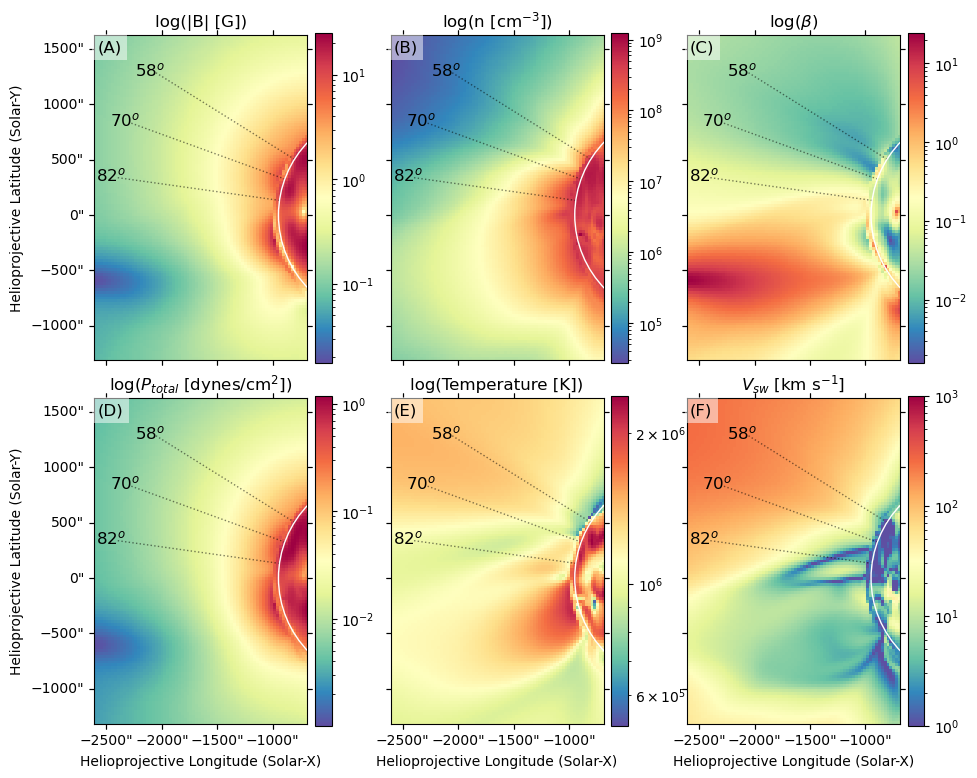

In [103]:
slits = True

fig = plt.figure(figsize=[11,9])
fig.supxlabel('Helioprojective Longitude (arcsec)', y=0.085)
fig.supylabel('Helioprojective Latitude (arcsec)', x=0.085)

ax  = fig.add_subplot(231, projection=bmag_submap)
img = bmag_submap.plot(axes=ax, title='log(|B| [G])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
bmag_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(A)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=bmag_submap, slit_length=1480)

ax  = fig.add_subplot(232, projection=dens_submap)
img = dens_submap.plot(axes=ax, title=r'log(n [cm$^{-3}$])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
dens_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(B)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=dens_submap, slit_length=1480)

ax  = fig.add_subplot(233, projection=beta_submap)
img = beta_submap.plot(axes=ax, title=r'log($\beta$)',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
beta_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(C)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=beta_submap, slit_length=1480)

ax  = fig.add_subplot(234, projection=ptot_submap)
img = ptot_submap.plot(axes=ax, title=r'log($P_{total}$ [dynes/cm$^2$])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
ptot_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.text(0.015, 0.985, '(D)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=ptot_submap, slit_length=1480)

ax  = fig.add_subplot(235, projection=temp_submap)
img = temp_submap.plot(axes=ax, title='log(Temperature [K])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
temp_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_ylabel(' ')
ax.coords[1].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(E)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=temp_submap, slit_length=1480)

ax  = fig.add_subplot(236, projection=Vsw_submap)
img = Vsw_submap.plot(axes=ax, title=r'$V_{sw}$ [km s$^{-1}$]',
            norm=colors.LogNorm(vmin=1, vmax=1000),
            cmap='Spectral_r')
Vsw_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_ylabel(' ')
ax.coords[1].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(F)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=Vsw_submap, slit_length=1480)
# cs = ax.contour(Vsw_submap.data, levels=[1e1, 1e2], colors='white')
# ax.clabel(cs, inline=True, fontsize=8, fmt='%.1e')

fig.subplots_adjust(wspace=0.14, hspace=0.1)
# fig.savefig(f'{data_dir}/forwardMaps_20240514.pdf',format='pdf', bbox_inches='tight')
plt.show()

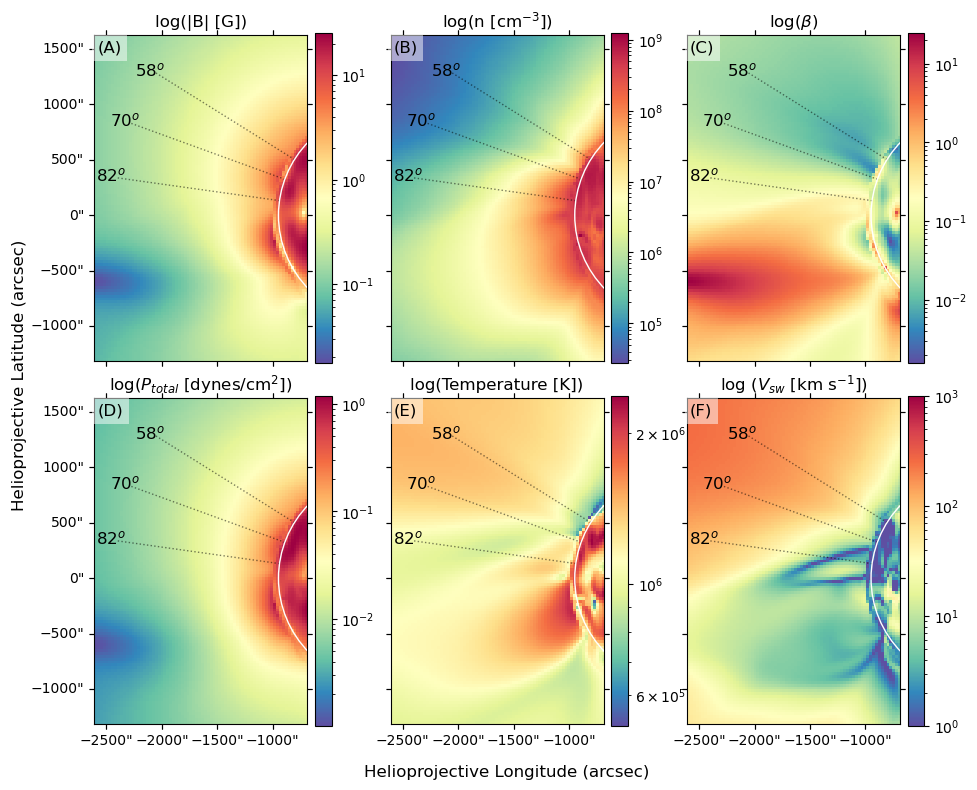

In [145]:
slits = True

fig = plt.figure(figsize=[11,9])
fig.supxlabel('Helioprojective Longitude (arcsec)', y=0.05)
fig.supylabel('Helioprojective Latitude (arcsec)', x=0.05)

ax  = fig.add_subplot(231, projection=bmag_submap)
img = bmag_submap.plot(axes=ax, title='log(|B| [G])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
bmag_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(A)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=bmag_submap, slit_length=1480)

ax  = fig.add_subplot(232, projection=dens_submap)
img = dens_submap.plot(axes=ax, title=r'log(n [cm$^{-3}$])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
dens_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(B)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=dens_submap, slit_length=1480)

ax  = fig.add_subplot(233, projection=beta_submap)
img = beta_submap.plot(axes=ax, title=r'log($\beta$)',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
beta_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(C)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=beta_submap, slit_length=1480)

ax  = fig.add_subplot(234, projection=ptot_submap)
img = ptot_submap.plot(axes=ax, title=r'log($P_{total}$ [dynes/cm$^2$])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
ptot_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.text(0.015, 0.985, '(D)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=ptot_submap, slit_length=1480)

ax  = fig.add_subplot(235, projection=temp_submap)
img = temp_submap.plot(axes=ax, title='log(Temperature [K])',
                norm=colors.LogNorm(),
                cmap='Spectral_r')
temp_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[1].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(E)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=temp_submap, slit_length=1480)

ax  = fig.add_subplot(236, projection=Vsw_submap)
img = Vsw_submap.plot(axes=ax, title=r'log ($V_{sw}$ [km s$^{-1}$])',
            norm=colors.LogNorm(vmin=1, vmax=1000),
            cmap='Spectral_r')
Vsw_submap.draw_limb(axes=ax)
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[1].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(F)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
draw_slits(axes=ax, map=Vsw_submap, slit_length=1480)

fig.subplots_adjust(wspace=0.14, hspace=0.1)
fig.savefig(f'{data_dir}/forwardMaps_20240514.pdf',format='pdf', bbox_inches='tight')
plt.show()

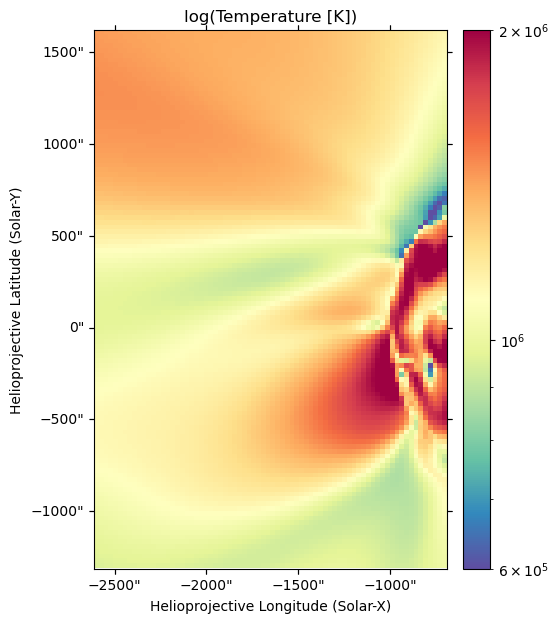

In [135]:
# Test ...
fig = plt.figure(figsize=[7,7])
ax  = fig.add_subplot(projection=temp_submap)
img = temp_submap.plot(axes=ax, title='log(Temperature [K])',
                norm=colors.LogNorm(vmin=6e5, vmax=2e6),
                cmap='Spectral_r')
plt.colorbar(img, ax=ax, pad=0.03)
ax.grid(False)
plt.show()

In [ ]:
# [
#     'log(Density [cm$^{-3}$])',
#     'log(Temperature [K])',
#     'log(|B| [G])',
#     'log(Plasma Beta)'
#     'log($P_{total}$ [dynes/cm$^2$])',
#     '$V_{alfven}$ [km s$^{-1}$]'
# ]

In [ ]:
# # Calculate the Alfven speed map
# mp = const.m_p.to(u.gram).value
# valf = bmag.data/np.sqrt(4*np.pi*mp*dens.data)/1e4
# VA = sunpy.map.Map(valf, dens.meta)

In [ ]:
# np.nanmax(VA.data), np.nanmin(VA.data)

In [ ]:
# fig = plt.figure(figsize=[7,7])
# ax = fig.add_subplot(projection=VA)
# img = VA.plot(axes=ax, vmin=1e1, vmax=3e3, title='$V_{alfven}$ [km s$^{-1}$]', cmap='Spectral_r')
# # VA.draw_limb()
# plt.colorbar(img, ax=ax, shrink=0.7, pad=0.05)
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [ ]:
# fig = plt.figure(figsize=[15,5])

# ax = fig.add_subplot(131, projection=dens)
# img = dens.plot(axes=ax,
#                       # vmin=0.5e2, vmax=1e4,
#                       norm=colors.LogNorm(),
#                       # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
#                 title='log(Density [cm$^{-3}$])',
#                       cmap='Spectral_r') # RdYlBu, Spectral
# # v_a.draw_limb()
# plt.colorbar(img, shrink=0.7, pad=0.05)
# ax.grid(False)

# ax = fig.add_subplot(132,projection=bmag)
# img = bmag.plot(axes=ax,
#                       # vmin=0.5e2, vmax=1e4,
#                       norm=colors.LogNorm(),
#                       # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
#                 title='log(|B| [G])',
#                       cmap='Spectral_r') # RdYlBu, Spectral
# # v_a.draw_limb()
# plt.colorbar(img, shrink=0.7, pad=0.05)
# ax.grid(False)

# ax = fig.add_subplot(133, projection=VA)
# img = VA.plot(axes=ax,
#                       vmin=1e1, vmax=3e3,
#                       # norm=colors.LogNorm(),
#                       # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
#               title='$V_{alfven}$ [km s$^{-1}$]',
#                       cmap='Spectral_r') # RdYlBu, Spectral
# # v_a.draw_limb()
# plt.colorbar(img, shrink=0.7, pad=0.05)
# ax.grid(False)

# fig.tight_layout()
# plt.show()

In [ ]:
# ###########################################################################
# #LOAD THE PSIMAS/FORWARD PLASMA DIAGNOSTICS
# diagnostics=['dens','temp','bmag','beta','ptot']
# diagmaps=[]
# for diagnostic in diagnostics:
#     psimas_diagfile = basedir+'psimas/psimas_diagnostic_'+diagnostic+'_'+psimas_date+'_'+psimasres+'.sav'
#     forwardmap = get_forward_map(psimas_diagfile)
#     mapsavefile = basedir+'psimas/psimas_diagnostic_map_'+diagnostic+'_'+psimas_date+'_'+psimasres+'.fits'
#     try: 
#         forwardmap.save(mapsavefile)
#     except:
#         pass
#     diagmaps.append(forwardmap)
#     forwardmap = None

# #Calculate the Alfven speed
# mp = 1.6726e-24
# valf = diagmaps[2].data/np.sqrt(4*np.pi*mp*diagmaps[0].data)/1.e4
# valfmap = sunpy.map.Map(valf, diagmaps[0].meta)
# diagnostic = 'valfven'
# mapsavefile = basedir+'psimas/psimas_diagnostic_map_'+diagnostic+'_'+psimas_date+'_'+psimasres+'.fits'
# try: 
#     valfmap.save(mapsavefile)
# except:
#     pass
# diagmaps.append(valfmap)

In [ ]:
# ##############################################################################
# # We will first begin be reading in the header and data from the SAV file.
# hdul = readsav(file_paths[-1])

# #####################################################################################
# # The data in this file is in a datacube structure
# data = np.array(hdul['quantmap'].DATA[0])
# ###############################################################################
# # Lets pull out the observation time and quantity, we will use
# # these to create our new header.
# # Now we need to get the other parameters from the header that will be used
# # to create the new header - here we can get the cdelt1 and cdelt2 which are
# # the spatial scales of the data axes.

# pxrsun = hdul['quantmap'][0][4]
# obstime = str(hdul['quantmap'][0][5]).split('\'')[1] + 'T12:00:00'
# quantity = str(hdul['quantmap'][0][6]).split('!')[0].split('\'')[1]
# try:
#     units = str(hdul['quantmap'][0][12]).split('\'')[1]
# except:
#     units = ''
# rsunasec = 950.
# asecpx = rsunasec * pxrsun
# cdelt1 = asecpx
# cdelt2 = asecpx
# naxis1 = hdul['gridinputs'][0][22]
# naxis2 = hdul['gridinputs'][0][24]
# crpix1 = int(naxis1/2)
# if type(naxis2) == bytes:
#     if naxis2.decode('utf-8') == 'NULL':
#         crpix2 = ''
#     else:
#         crpix2 = int(naxis2.decode('utf-8')/2)
# else:
#     crpix2 = int(naxis2/2)
# crval1 = 0
# crval2 = 0

# ###############################################################################
# # To create a new `~sunpy.map.Map` header we need convert the reference coordinate
# # to Helioprojective. To do this we will first create
# # an `astropy.coordinates.SkyCoord` of the reference coordinate from the header information.
# # We will need the location of the observer (i.e. where the observation was taken).
# reference_coord = SkyCoord(crval1*u.arcsec, crval2*u.arcsec, frame='helioprojective', obstime=obstime)
# ##########################################################################

# ##########################################################################
# # Now we can use this information to create a new header using the helper
# # function `~sunpy.map.make_fitswcs_header()`. This will create a MetaDict
# # which we contain all the necessay WCS information to create a `~sunpy.map.Map`.
# new_header = sunpy.map.make_fitswcs_header(data, reference_coord,
#                                            reference_pixel=u.Quantity([crpix1, crpix1]*u.pixel),
#                                            scale=u.Quantity([cdelt1, cdelt2]*u.arcsec/u.pix),
#                                            rotation_angle=0*u.degree,
#                                            observatory='PSIMAS/FORWARD', instrument=quantity)
# ##########################################################################
# # Lets create a `~sunpy.map.Map`.
# forward_map = sunpy.map.Map(data, new_header)
# ##########################################################################
# ##########################################################################
# # We can now rotate the image so that solar north is pointing up and create
# # a submap in the field of view of interest.
# forwardmap = forward_map.rotate()

In [ ]:
# Load the .sav file
data = readsav(file_paths[-1])

In [ ]:
data

In [ ]:
# List all variables and their types
for var_name, var_data in data.items():
    print(f"Variable: {var_name}, Type: {type(var_data)}")

In [ ]:
data['obspramsstruct'].dtype.names

In [ ]:
obs_date = data['obspramsstruct'].DATE[0].decode('utf-8') # Decode bytes to string using UTF-8 encoding
print(obs_date)

In [ ]:
data['obspramsstruct'].item()

In [ ]:
[x for x in dir(data['quantmap']) if not x.startswith('_')]

In [ ]:
data['quantmap'].DATA[0].shape

In [ ]:
plt.figure()
plt.imshow(data['quantmap'].DATA[0][::-1], aspect='auto')
plt.show()

In [ ]:
for item in data['obspramsstruct'].item():
    print(item)

In [ ]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.coordinates import frames

In [ ]:
b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}

In [ ]:
for name in data.gridpramsstruct.item():
    print(name)

In [ ]:
# # getting header info for a given time index
# b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}

# # Constuct the NRH image
# map_data = nrh['nrh_data'][image_index]

# ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
#                      frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
#                      )
# header = sunpy.map.make_fitswcs_header(map_data,
#                                        ref_coord,
#                                        reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
#                                        scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
#                                        wavelength=float(b['FREQ'])*u.MHz)
# nrh_map = sunpy.map.Map(map_data, header)

In [ ]:
# coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=obs_date, observer='earth', frame=frames.Helioprojective)

In [ ]:
# # List all variables and their types
# for item in data['quantmap'].item():
#     print(item)